<a href="https://colab.research.google.com/github/arjuns2197/Active-Galactic-Nuclei/blob/main/agn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import astropy # the general library of Python routines for astronomy 

The point of this project is to understand the population of Active Galactic Nuclei in the local Universe. These are supermassive black holes at the centers of galaxies, which are shining brightly because they are accreting matter. They are thought to play an important role in the evolution of galaxies.

There are many ways to detect AGN. You can read a little introduction to AGN [at this site](https://blanton144.github.io/exex/). You may find it useful to look at [these slides, starting at slide 568 (!)](https://www.dropbox.com/s/15lq5ucha96e8m2/extragalactic-slides.pdf?dl=0). The book Extragalactic Astronomy and Cosmology by Peter Schneider is a more thorough reference.

We will concentrate here on detecting them through their radio emission. This is synchrotron emission from those AGN that are emitting jets of gas. These are often known as "radio galaxies." The standard lore is that these radio galaxies are preferentially found in red galaxies, which are not forming stars.

However, I am concerned that this lore might be misleading because of selection effects. Basically, star formation also produces radio emission, which can outshine the AGN. So the question is, can we really conclude that star forming galaxies do not have radio AGN, or is the star formation just hiding them?



To address this question we will use a sample of nearby galaxies with very well measured optical properties from the MaNGA survey.You can find a description at [this site](https://www.sdss.org/surveys/manga). 

The path forward is:

 * Acquire and understand the optical data, and how the star formation, masses, and other properties of galaxies are related to each other.
 * Match the optical data to a radio data set, which will match to both star-forming galaxies and AGN.
 * For star-forming galaxies, calibrate the relationship between estimated star formation rate in the optical and the radio emission.
 * For each galaxy, use known relationships between galaxy properties and the central black hole mass to convert an assumed "Eddington ratio" (I'll explain that later) to radio emission.
 * Determine the Eddington ratio distribution as a function of star formation rate (actually "specific star formation rate", which I will also explain later), accounting for the fact that the AGN may be outshone by the star formation. This will allow us to answer the question as to whether the AGN are really preferentially in low star formation galaxies.

To start you just need to get a hold of the data and be able to make some simple plots.

We can just start with the public data. We need two sets of results, from the "[Data Analysis Pipeline](https://www.sdss.org/dr16/manga/manga-analysis-pipeline/)" and from "[PIPE3D](https://www.sdss.org/dr16/data_access/value-added-catalogs/?vac_id=manga-pipe3d-value-added-catalog:-spatially-resolved-and-integrated-properties-of-galaxies-for-dr15)". 

For radio properties, we will want to download the FULL catalog of sources from [Best & Heckman 2012](https://ui.adsabs.harvard.edu/abs/2012MNRAS.421.1569B/abstract), available here: https://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J/MNRAS/421/1569

You will want all of this data in FITS format, which is a standard astronomical format.

In this notebook, if you upload the data and read it in with astropy.io.fits (see astropy.org for docs) I can guide you as to what plots to make etc.

In [3]:
from astropy.io import fits
from astropy.utils.data import download_file
url_pipe3d = 'https://dr15.sdss.org/sas/dr15/manga/spectro/pipe3d/v2_4_3/2.4.3/manga.Pipe3D-v2_4_3.fits'
path_pipe3d= download_file(url_pipe3d, cache= True)
data_pipe3d= fits.open(path_pipe3d)[1].data
url_dap= 'https://data.sdss.org/sas/dr16/manga/spectro/analysis/v2_4_3/2.2.1/dapall-v2_4_3-2.2.1.fits'
path_dap = download_file(url_dap, cache= True)
data_dap = fits.open(path_dap)[1].data
url_bestheckman12 = 'https://drive.google.com/uc?id=1RhfH3OJ2pF_TTXMcPk0ks7WZfv5zx3fj&export=download'
path_bhm12= download_file(url_bestheckman12) #bhm is short for bestheckman
data_bhm12= fits.open(path_bhm12)[1].data





    






As you begin looking at the data, it occurs to me that it will be helpful to first understand the galaxy properties. You might look at [Blanton and Moustakas (2009)](https://ui.adsabs.harvard.edu/abs/2009ARA%26A..47..159B/abstract) and/or the Galaxies notes at https://blanton144.github.io/exex/ 

You can use the PIPE3D results to plot some of the basic quantities against each other. You should use the [data model](https://data.sdss.org/datamodel/files/MANGA_PIPE3D/MANGADRP_VER/PIPE3D_VER/manga.Pipe3D.html) to figure out what the parameters mean.

I recommend starting with:



*   Stellar mass 
*   Velocity dispersion
*   Star formation rate
*   Oxygen abundance

Once you have done this we can meet to discuss the results so I can describe them to you and I can answer questions.



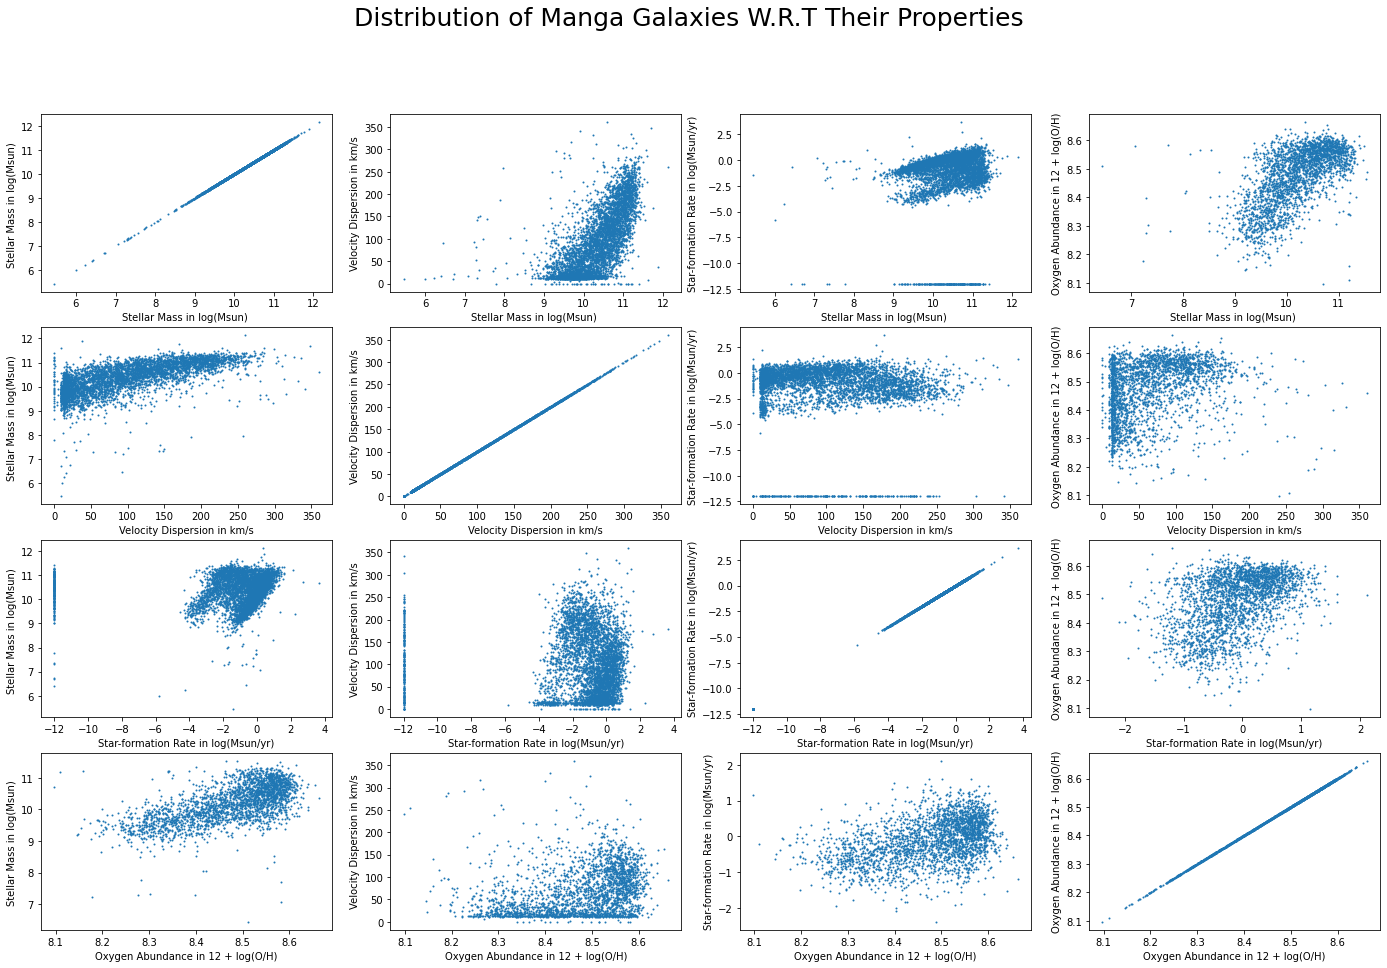

In [4]:
import matplotlib.pyplot as plt
stellar_mass= data_pipe3d.field('log_Mass')
velocity_dispersion= data_pipe3d.field('sigma_cen')
star_formation_rate= data_pipe3d.field('log_SFR_Ha')
oxygen_abundance= data_pipe3d.field('OH_Re_fit_O3N2')
quantities = [(0,stellar_mass,'Stellar Mass in log(Msun) '),(1,velocity_dispersion,'Velocity Dispersion in km/s'),(2,star_formation_rate,'Star-formation Rate in log(Msun/yr)'),(3,oxygen_abundance,'Oxygen Abundance in 12 + log(O/H)')]
fig, axes = plt.subplots(nrows=4, ncols=4,figsize=(24,15))
plt.suptitle("Distribution of Manga Galaxies W.R.T Their Properties", fontsize = 25)
for i in quantities:
  for j in quantities:
    axes[i[0],j[0]].scatter(i[1],j[1],s=1)
    axes[i[0],j[0]].set(xlabel= i[2], ylabel= j[2]) 
plt.show()




The next step is matching this catalog to the Best & Heckman catalog. The most reliable way is just by position on the sky (right ascension and declination, i.e. RA and Dec).

The matching process is slow if you do the comparison explicitly between RA and Dec for every potential match. 

Instead what you should do is to use astropy's coordinates module: https://docs.astropy.org/en/stable/coordinates/index.html



In [5]:
from astropy import units as u
from astropy.coordinates import SkyCoord
c_bhm12 = SkyCoord(ra=data_bhm12['RAJ2000']*u.degree, dec=data_bhm12['DEJ2000']*u.degree, frame='icrs')








With this new SkyCoord object, along with one created from the PIPE3D outputs, you can use the matching methods: https://docs.astropy.org/en/stable/coordinates/matchsep.html#astropy-coordinates-matching

You will want to use "match_to_catalog_sky". You will also only want to keep matches that are close enough, say within 2 arcsec. This will leave some objects out, which is OK.

Once you have a match, you should plot redshift in B&H vs redshift in PIPE3D to make sure it makes sense.

After that, you will need to calculate the luminosity in the radio. That will be a conversion of the fluxes in mJy to erg/s/Hz. This will require some unit conversion and also multiplying by $4\pi D^2$, where $D$ is the luminosity distance. For a more complete discussion see the "Light I" notes here: https://blanton144.github.io/exex/

We will infer the distance using the Hubble Law $v=H_0 D$ relating the recession velocity of a galaxy to its distance. But at cosmological distances you have to specify a specific definition of distance, the luminosity disance. To calculate the luminosity distance based on the redshift, you should again use astropy, in particular its cosmology module: https://docs.astropy.org/en/stable/cosmology/index.html


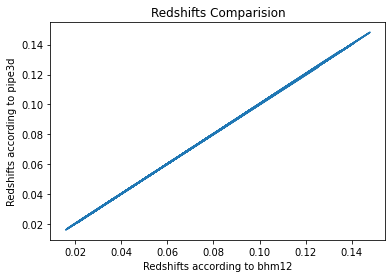

In [6]:
c_pipe3d = SkyCoord(ra=data_pipe3d['objra'], dec= data_pipe3d['objdec'], frame= 'icrs', unit='deg') 
idx, sep2d, d3d = c_bhm12.match_to_catalog_sky(c_pipe3d)
max_sep = 2*u.arcsec
sep_constraint = sep2d < max_sep
matches_bhm12 = data_bhm12[sep_constraint]
matches_pipe3d = data_pipe3d[idx[sep_constraint]]
redshift_bhm12=matches_bhm12['z']
redshift_pipe3d= matches_pipe3d['redshift']
fig, ax = plt.subplots()
ax.plot(redshift_bhm12,redshift_pipe3d)
ax.set_title("Redshifts Comparision")
ax.set_xlabel("Redshifts according to bhm12")
ax.set_ylabel("Redshifts according to pipe3d")
plt.show()



In [7]:
#import numpy as np
#separations = np.arange(0,200,2)
#a=[]
#for i in separations:
  #max_sep = i*u.arcsec
  #sep_constraint = sep2d < max_sep
  #matches_bhm12 = c_bhm12[sep_constraint]
  #a.append(len(matches_bhm12))  
#plt.hist(a,bins=100,edgecolor='black')
#plt.show()



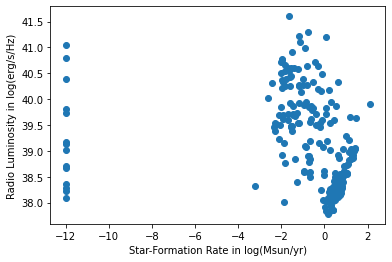

In [8]:
from astropy.cosmology import WMAP9 as cosmo
import numpy as np
radio_fluxes = 1.4e9*matches_bhm12['SNVSS']*1e-26*u.erg/(u.s*u.cm*u.cm*u.Hz)
distance_L= cosmo.luminosity_distance(redshift_bhm12).cgs  
radio_L = radio_fluxes*(4*np.pi*distance_L*distance_L) # In erg/s/Hz.
radio_L=np.log10(radio_L.value)
star_formation = matches_pipe3d['log_SFR_Ha']
fig, ax = plt.subplots()
ax.scatter(star_formation,radio_L)
ax.set_xlabel("Star-Formation Rate in log(Msun/yr)")
ax.set_ylabel("Radio Luminosity in log(erg/s/Hz)")
plt.show()













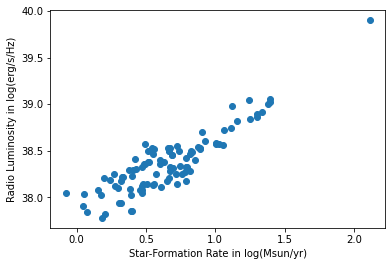

In [9]:
from matplotlib.widgets import Cursor, Button
A=np.array([0.65,38.8]) # Points to the right of the line AB are considered for regression
B= np.array([1.1,39.15])
points= np.array(list(zip(star_formation,radio_L)))
AB=np.array([B[0]-A[0],B[1]-A[1]])
lst=[]
for point in points:
  r=np.array([point[0]-A[0],point[1]-A[1]])
  cross_product= (AB[0]*r[1])-(r[0]*AB[1])
  if cross_product <= 0:
    lst.append(point)
required_points = np.array(lst) # each element is a pair of star formation and the corresponding radio luminosity
fig, ax = plt.subplots()
ax.scatter(required_points[:,0:1],required_points[:,1:2])
ax.set_xlabel("Star-Formation Rate in log(Msun/yr)")
ax.set_ylabel("Radio Luminosity in log(erg/s/Hz)")
plt.show()








  

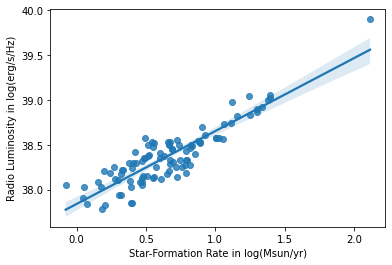

The R-squared score of the fit is 0.79471385596842


In [10]:
from sklearn.linear_model import LinearRegression
import seaborn as sns
lm = LinearRegression()
lm.fit(required_points[:,0:1],required_points[:,1:2])
a=lm.coef_
b= lm.intercept_
fig, ax = plt.subplots()
sns.regplot(x=required_points[:,0:1],y=required_points[:,1:2])
ax.set_xlabel("Star-Formation Rate in log(Msun/yr)")
ax.set_ylabel("Radio Luminosity in log(erg/s/Hz)")
plt.show()
print("The R-squared score of the fit is",lm.score(required_points[:,0:1],required_points[:,1:2]))




We want to measure the radio luminosity limit for each MaNGA galaxy. This means the lowest radio luminosity that the galaxy COULD have and still be detected.

For galaxies with detected radio, the luminosity limit will always be below the detected radio luminosity. For galaxies without detected radio, the luminosity limit gives us an upper limit on the luminosity.

The reason we want to know this number for each MaNGA galaxy is that we want to know the extent to which the distribution of luminosities we observe is affected by these limits.

The limiting luminosity is relatively simple to calculate and only depends on the redshift. The flux limit is $f_{\rm lim} =$ 5 mJy, and therefore $L_{\rm lim} = 4\pi D_L^2 f_{\rm lim}$, where $D_L$ is the luminosity distance and depends on the redshift $z$ of the MaNGA galaxy. 

A useful first plot would be to plot the radio luminosities AND the luminosity limits (in a different color) vs. the star formation rate. Another useful one would be the radio luminosities and limits vs. redshift (the limits should all be on a thin line in that plot). 





In [11]:
redshifts= data_pipe3d['redshift']
distance_lumi = cosmo.luminosity_distance(redshifts).cgs
L_lim1 = np.log10(4*np.pi*(distance_lumi.value*distance_lumi.value)*5e-26*1.4e9)


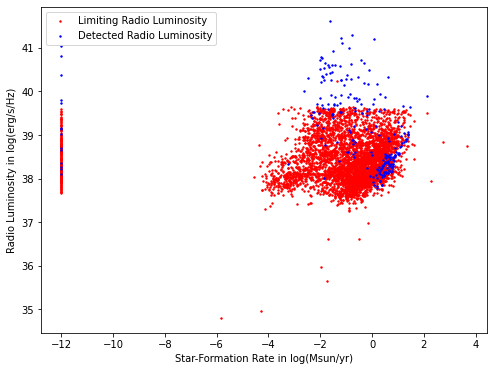

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x=star_formation_rate,y=L_lim1,c='r',label='Limiting Radio Luminosity',s=2)
ax.scatter(x=star_formation,y=radio_L,c='b',label='Detected Radio Luminosity',s=2)
#ax.scatter(x=star_formation,y=L_lim_detected,c='g',label='Limiting Radio Luminosity of Radio-Detected Galaxies',s=2)
ax.set_xlabel("Star-Formation Rate in log(Msun/yr)")
ax.set_ylabel("Radio Luminosity in log(erg/s/Hz)")
ax.legend()
plt.show()


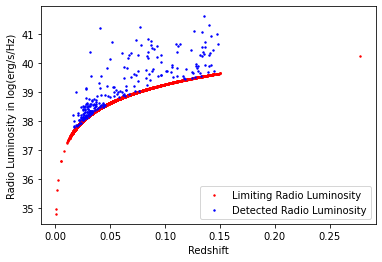

In [13]:
fig, ax = plt.subplots()
ax.scatter(x=redshifts,y=L_lim1,c='r',label='Limiting Radio Luminosity',s=2)
ax.scatter(x=redshift_pipe3d,y=radio_L,c='b',label='Detected Radio Luminosity',s=2)
ax.set_xlabel("Redshift")
ax.set_ylabel("Radio Luminosity in log(erg/s/Hz)")
ax.legend()
ax.legend()
plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


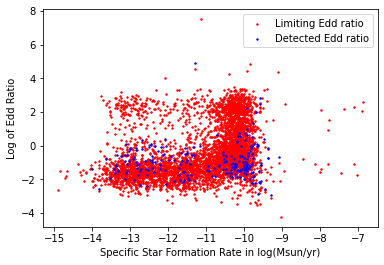

In [14]:
indices1 = np.where(matches_pipe3d['log_SFR_Ha']> -4)
log_mass_BH1 = np.float64(8.12+4.24*np.log10(matches_pipe3d['sigma_cen'][indices1]/200))  # log(M_bh/Msun)
log_L_Edd1= np.float64(np.log10(1.26e38)+log_mass_BH1)
L_Edd1= 10**log_L_Edd1
log_L_XR1 = np.float64(0.925*radio_L[indices1]+7.1)
L_XR1= 10**log_L_XR1
L_Bolo1= 20*(L_XR1)
lambda_1 = L_Bolo1/L_Edd1

indices2 = np.where(data_pipe3d['log_SFR_Ha'] > -4)
log_mass_BH_all1 = np.float64(8.12+4.24*np.log10(data_pipe3d['sigma_cen'][indices2]/200)) 
log_L_Edd_all1 = np.float64(np.log10(1.26e38)+log_mass_BH_all1)
L_Edd_all1= 10**log_L_Edd_all1
log_L_XR_all1 = np.float64(0.925*L_lim1[indices2]+7.1)
L_XR_all1 = 10**log_L_XR_all1
L_Bolo_all1 = 20*L_XR_all1
lambda_lim1 = L_Bolo_all1/L_Edd_all1

fig, ax = plt.subplots()
ax.scatter(x=np.log10(10**star_formation_rate[indices2]/10**stellar_mass[indices2]),y=np.log10(lambda_lim1),c='r',label='Limiting Edd ratio',s=2)
ax.scatter(x=np.log10(10**star_formation[indices1]/10**matches_pipe3d['log_Mass'][indices1]),y=np.log10(lambda_1),c='b',label='Detected Edd ratio',s=2)
ax.set_xlabel("Specific Star Formation Rate in log(Msun/yr)")
ax.set_ylabel('Log of Edd Ratio')
ax.legend()
plt.show()



We want to look at the above results also in terms of the Eddington ratio. The Eddington luminosity is defined as:

$L_{\rm Edd} = \frac{4\pi G c m_p M_{\rm BH}}{\sigma_T} \approx 1.26\times 10^{38} \frac{M_{\rm BH}}{M_\odot} {\rm ~ergs~s}^{-1}$

and the Eddington ratio is defined as:

$\lambda = \frac{L_{\rm bol}}{L_{\rm Edd}}$

The bolometric luminosity is the "total" luminosity from the quasar. This is a very uncertain quantity but there are some standard relations that will get us in the right ballpark. The radio luminosity can be related to the luminosity in the X-rays (within the 2-10 keV range) using a relation from Panessa et al. (2015) (https://ui.adsabs.harvard.edu/abs/2015MNRAS.447.1289P/abstract):

$\log_{10} L_X = 0.925 \log_{10} L_{1.4 \rm GHz} + 7.1$

Then the standard conversion from $L_X$ in that range of energies to bolometric luminosity is to multiply by 20 (Marconi et al. 2004). Obviously this isn't going to be exactly right for every galaxy, but this is nevertheless reasonable enough for us to do I think.

But we also need the black hole mass. For this we use the $M$-$\sigma$ relation. This relates the velocity dispersion in the bulge of a galaxy (generally quite a bit bigger than the sphere of influence of the black hole) to the black hole mass. For example, we have the following determination from Gultekin et al (2009) (https://ui.adsabs.harvard.edu/abs/2009ApJ...698..198G/abstract):

$\log_{10}(M_\mathrm{BH}/M_\odot) = 8.12+4.24\log_{10}(\sigma/200\mathrm{km\ s}^{-1}) $

So for our MaNGA galaxies, even though we cannot directly measure the black hole mass, this relationship allows us to connect them, because the PIPE3D results have an estimate of $\sigma$ in them.

These relationships should allow you to make plots with $\lambda$ instead of $L_{\rm radio}$. That will be useful because $\lambda$ is a better reflection of how active a black hole is given its mass. 

Another helpful thing to do would be to look at "specific" SFR instead of SFR. The "sSFR" is just defined as SFR divided by the stellar mass. 

In [15]:
indices_SFR = np.where(matches_pipe3d['log_SFR_Ha']>-4)
matches_pipe3d_mdfied = matches_pipe3d[indices_SFR]
indices_stellar_mass = np.where(matches_pipe3d_mdfied['log_Mass']>9)
matches_pipe3d_mdfied1 = matches_pipe3d_mdfied[indices_stellar_mass]
indices_sigma = np.where(matches_pipe3d_mdfied1['sigma_cen']>50)
matches_pipe3d_modified = matches_pipe3d_mdfied1[indices_sigma]
modified_SF = matches_pipe3d_modified['log_SFR_Ha']

radio_L_sfr = lm.intercept_ + lm.coef_*modified_SF + 0.5
radio_L_sfr=radio_L_sfr.reshape(len(modified_SF),)
indices_not_SF = np.where(radio_L_sfr < radio_L[indices_SFR][indices_stellar_mass][indices_sigma])
radio_L_AGN = radio_L[indices_SFR][indices_stellar_mass][indices_sigma][indices_not_SF]


SF_radio_lim = lm.intercept_ + lm.coef_*data_pipe3d['log_SFR_Ha']+0.5
SF_radio_lim = SF_radio_lim.reshape(4656,)

L_lim_modified = L_lim1

for i in range(len(L_lim1)):
  if SF_radio_lim[i] > L_lim_modified[i]:
    L_lim_modified[i] = SF_radio_lim[i] 



In [16]:
log_mass_BH = np.float64(8.12+4.24*np.log10(matches_pipe3d_modified['sigma_cen'][indices_not_SF]/200))  # log(M_bh/Msun)
log_L_Edd= np.float64(np.log10(1.26e38)+log_mass_BH)
L_Edd= 10**log_L_Edd
log_L_XR = np.float64(0.925*radio_L_AGN+7.1)
L_XR= 10**log_L_XR
L_Bolo= 20*(L_XR)
lambda_ = L_Bolo/L_Edd






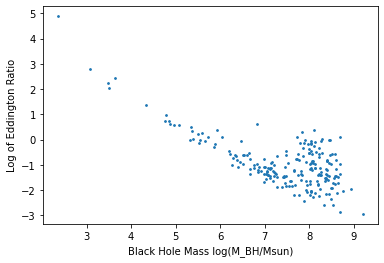

In [17]:
fig, ax = plt.subplots()
ax.scatter(log_mass_BH1, np.log10(lambda_1), s=3)
ax.set_xlabel("Black Hole Mass log(M_BH/Msun)")
ax.set_ylabel("Log of Eddington Ratio")
plt.show()

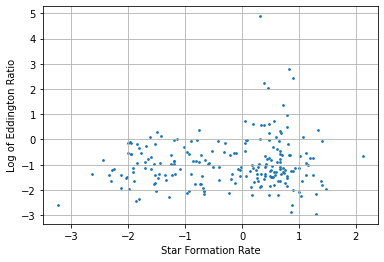

In [18]:
fig, ax = plt.subplots()
ax.scatter(star_formation[indices1], np.log10(lambda_1), s=3)
ax.set_xlabel("Star Formation Rate")
ax.set_ylabel("Log of Eddington Ratio")
plt.grid()
plt.show()



In [19]:
indices = np.where(data_pipe3d['log_SFR_Ha']>-4)
data_pipe3d_mdfied = data_pipe3d[indices]
indices_sigma_pipe3d = np.where(data_pipe3d_mdfied['sigma_cen']>50)
data_pipe3d_mdfied1 = data_pipe3d_mdfied[indices_sigma_pipe3d] 
log_mass_BH_all = np.float64(8.12+4.24*np.log10(data_pipe3d_mdfied1['sigma_cen']/200)) 
log_L_Edd_all = np.float64(np.log10(1.26e38)+log_mass_BH_all)
L_Edd_all= 10**log_L_Edd_all
log_L_XR_all = np.float64(0.925*L_lim_modified[indices][indices_sigma_pipe3d]+7.1)
L_XR_all = 10**log_L_XR_all
L_Bolo_all = 20*L_XR_all
lambda_lim = L_Bolo_all/L_Edd_all


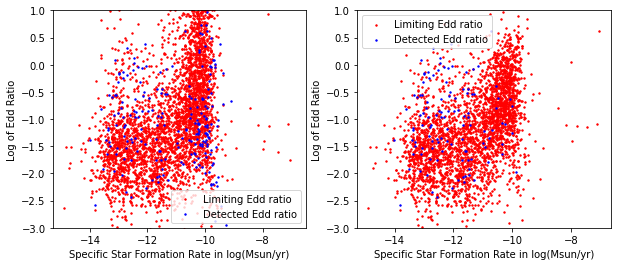

In [20]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(x=np.log10(10**star_formation_rate[indices2]/10**stellar_mass[indices2]),y=np.log10(lambda_lim1),c='r',label='Limiting Edd ratio',s=2)
ax[0].scatter(x=np.log10(10**star_formation[indices1]/10**matches_pipe3d['log_Mass'][indices1]),y=np.log10(lambda_1),c='b',label='Detected Edd ratio',s=2)
ax[0].set_xlabel("Specific Star Formation Rate in log(Msun/yr)")
ax[0].set_ylabel('Log of Edd Ratio')
ax[0].set_ylim(-3,1)
ax[0].legend()
ax[1].scatter(x=np.log10(10**star_formation_rate[indices][indices_sigma_pipe3d]/10**stellar_mass[indices][indices_sigma_pipe3d]),y=np.log10(lambda_lim),c='r',label='Limiting Edd ratio',s=2)
ax[1].scatter(x=np.log10(10**modified_SF[indices_not_SF]/10**matches_pipe3d_modified['log_Mass'][indices_not_SF]),y=np.log10(lambda_),c='b',label='Detected Edd ratio',s=2)
ax[1].set_xlabel("Specific Star Formation Rate in log(Msun/yr)")
ax[1].set_ylabel('Log of Edd Ratio')
ax[1].legend()
ax[1].set_ylim(-3,1)
plt.show()


In [21]:
# Maximum Likelihood Estimate
from numpy import inf

def func(x, mean, std):
  root_2pi = np.sqrt(2*np.pi)
  p_Xi=(1/(root_2pi*std))*np.exp(-0.5*((x-mean)/std)**2)
  return p_Xi

#Likelihood function  
def ln_p_1(theta):
  mean= theta[0]
  std= theta[1]
  p_Xi= func(np.log10(lambda_),mean,std)
  ln_p_x = np.log(p_Xi).sum()
  

  xlo = -4.
  xhi = 4.
  n = 100000
  dx = (xhi - xlo) / np.float32(n)
  x = xlo + dx * (np.arange(n, dtype=np.float32) + 0.5) 
  f = func(x,mean,std)

  xs = x + 0.5*dx
  cf = f.cumsum() * dx

  import scipy.interpolate

  intcf = scipy.interpolate.interp1d(xs, cf, kind='cubic', assume_sorted=False, bounds_error=False, fill_value='extrapolate')
  ln_p_x = ln_p_x + np.log(intcf(np.log10(lambda_lim))).sum()

  return ln_p_x

def ln_p_maximization(theta):
  return -1*ln_p_1(theta)

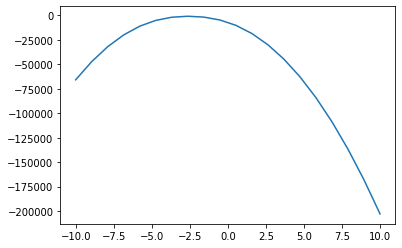

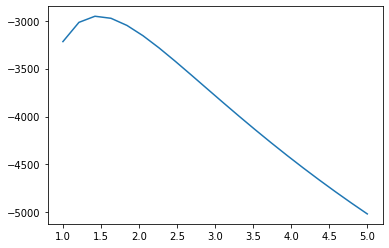

In [22]:
fig, ax = plt.subplots()
means = np.linspace(-10,10,20)
arr = np.zeros(len(means))
for i in range(len(means)):
  arr[i] = ln_p_1([means[i],1])
ax.plot(means,arr)   
plt.show()

fig, ax = plt.subplots()
stds = np.linspace(1,5 ,20)
arr1 = np.zeros(len(stds))
for i in range(len(stds)):
  arr1[i] = ln_p_1([-1,stds[i]])
ax.plot(stds,arr1)  
plt.show()

In [23]:
from scipy.optimize import minimize
mean_start = 4
std_start = 2
theta_start = [mean_start,std_start]
result = minimize(ln_p_maximization,theta_start, method= 'Nelder-Mead')
print(result.x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log


[-2.60928848  0.6621246 ]


In [24]:
import scipy.integrate as integrate
lambda_min = 1e-10

def Schechter(x, alpha, lambda_star):
  p_Xi= (x/lambda_star)**(-alpha)*np.exp(-x/lambda_star)
  return p_Xi

In [25]:
def normalisation(alpha  , lambda_star):
  temp= integrate.quad(lambda z: Schechter(z,alpha,lambda_star), lambda_min, inf )[0]
  return 1/temp


In [77]:
# Maximum Likelihood Estimate
 
def ln_p_sch(theta): # Likelihood Function
  alpha = theta[0]
  lambda_star = theta[1]
  p_Xi= normalisation(alpha, lambda_star)*Schechter(lambda_,alpha,lambda_star)
  ln_p_x = np.log(p_Xi).sum()


  xlo = lambda_min
  xhi = 1000.
  n = 1000000
  
  dx = (xhi - xlo) / np.float32(n)
  x = xlo + dx * (np.arange(n, dtype=np.float32) + 0.5) 
  f = normalisation(alpha, lambda_star)*Schechter(x,alpha,lambda_star)

  xs = x + 0.5*dx
  cf = f.cumsum() * dx

  import scipy

  intcf = scipy.interpolate.interp1d(xs, cf, kind='cubic', assume_sorted=False, bounds_error=False, fill_value='extrapolate')
  ln_p_x = ln_p_x+ np.log(intcf(lambda_lim)).sum()


  return ln_p_x

def ln_p_sch_maxi(theta):
  return -1*ln_p_sch(theta)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


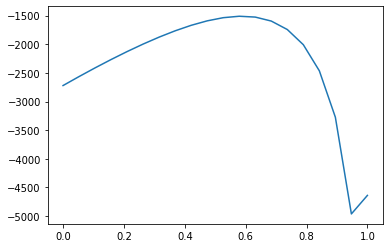

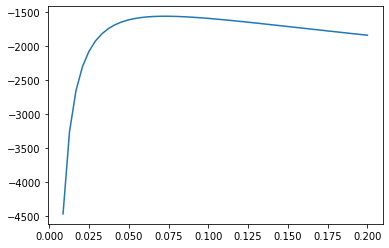

In [78]:
fig, ax = plt.subplots()
alphas = np.linspace(0,1,20)
arr_sch = np.zeros(len(alphas))
for i in range(len(alphas)):
  if ln_p_sch([alphas[i],1]) != np.nan and ln_p_sch([alphas[i],1]) != inf:
    arr_sch[i] = ln_p_sch([alphas[i],0.06779434])
ax.plot(alphas,arr_sch)   

fig, ax = plt.subplots()
lam_stars = np.linspace(0.0005,0.2,50)
arr_sch1 = np.zeros(len(lam_stars))
for i in range(len(lam_stars)):
  if ln_p_sch([0.66237497,lam_stars[i]]) != np.nan and ln_p_sch([0.66237497,lam_stars[i]]) != inf:
    arr_sch1[i] = ln_p_sch([0.66237497,lam_stars[i]])
ax.plot(lam_stars,arr_sch1) 
plt.show()


In [79]:
from scipy.optimize import minimize
alpha_start = 0.5
lambdastr_start = 1
theta_start = [alpha_start,lambdastr_start]
result = minimize(ln_p_sch_maxi,theta_start, method= 'Nelder-Mead')
print(result.x) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """


[0.5635451  0.05649621]


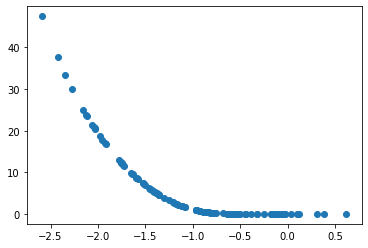

In [96]:
plt.scatter(np.log10(lambda_),normalisation(result.x[0],result.x[1])*Schechter(lambda_,result.x[0],result.x[1]))
plt.show()
